In [1]:
cd /Users/nbeshouri/Documents/Projects/Metis/Project 2

/Users/nbeshouri/Documents/Projects/Metis/Project 2


In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from wikigrader import data, scraper, utils, predict

plt.rcParams['figure.dpi'] = 150

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Wikigrader

## Objective

Wikipedia [grades](https://en.wikipedia.org/wiki/Wikipedia:WikiProject_Wikipedia/Assessment#Quality_scale) its articles so that it can make the best use of its limited resources. This is currently a manual process, and a never ending one given the dynamic and expanding nature of Wikipedia. My goal was to investigate the feasibility of building a tool that could partially automate this process, or at the very least suggest when an article's rating might be out of date.

## Scraping, attempt the first

The Wikimedia foundation provides a [web tool](https://xtools.wmflabs.org/articleinfo/en.wikipedia.org) that provides detailed statistics for any given article. Scraping these pages with `bs4` was relatively straightforward, but knowing which article to scrape was less so. I initially tried picking articles at random from a downloaded list of all english language wikipedia articles, but the relative rarity of the higher rated articles meant that I only had a handful of examples even after scraping data on thousands of articles.

## Scraping, attempt the second

I was eventually fortunate enough to find a [link](https://en.wikipedia.org/wiki/Special:RandomInCategory/Featured_articles) that would return a random "Featured Article" (FA) class article. From there, I was able extract its canonical name and get its statistics from the Wikimedia Foundation. This technique worked identically for "Good Article" (GA) class articles. Other article grades (Stub, Start, C, B, A) had to be handled with a slightly more complex process, but I was eventually able to write a function that could loop through the 6 different article grades and take one random sample from each (i.e. stratified sampling). My final sample count was:

In [28]:
raw_df = data.import_raw_data()
raw_df['Assessment'].value_counts()

Start    2448
Stub     2248
C        2102
GA       1978
B        1841
FA       1321
A         490
Name: Assessment, dtype: int64

## Data wrangling

After minor cleaning, I converted the raw data into a `DataFrame` with 45 fields:

In [16]:
raw_df = data.import_raw_data()
raw_sample_df = raw_df.sample(4, random_state=42)
display(raw_sample_df.set_index('Name').T)

Name,Xander_Harris,Open_Web_Analytics,Liberal_Party_(UK),Leichttraktor
Account edits,624,18,769,92
Assessment,C,Stub,C,Stub
Average edits per day,0.2,0,0.2,0.1
Average edits per month,5.4,0.3,5.3,1.7
Average edits per user,2.1,1.3,2.2,2.2
Average edits per year,64.4,4.1,63.3,20.4
Average time between edits (days),5.7,89.7,5.8,17.9
Bot edits,23,0,68,11
Bottom 90%,705,8,745,48
Bugs,1,0,0,0


 Some of these I immediately transformed (e.g. start date to article age) and some of them I transformed later after looking at pairplots and running test regressions. 

I also created a "Rating" field that maped Wikipedia's letter grade style ratings to numeric ones. For all grades but A, this was a straight forward linear mapping. I merged A with GA because they seemed very similar and A was the least frequently used article grade. (In my earlier non-stratified sampling, I only found 1 article with an A rating in over 5000 samples.)

In [33]:
transformed_df = data.transform_data(raw_df)
transformed_sample_df = transformed_df.sample(4, random_state=42)
transformed_sample_df[['Name', 'Rating'] + data.simple_features].T

,16298,12394,14660,16461
Name,Xander_Harris,Open_Web_Analytics,Liberal_Party_(UK),Leichttraktor
Rating,2,0,2,0
Account edits (ratio),0.63869,0.75,0.73659,0.821429
Age (days) (log),8.62155,7.72489,8.70467,7.72842
Average edits per day (log),-1.60944,0,-1.60944,-2.30259
Bugs,1,0,0,0
Categories,13,8,13,12
Words (log),8.34117,4.70953,8.92452,5.44242
Editors (log),6.1591,2.89037,6.16121,3.93183
File links (log),2.07944,1.38629,2.83321,1.38629


## Feature selection

I started by giving most of the numeric features I thought would be predictive to `statsmodels` OLS model and dropping the insignificant terms, yielding:

In [29]:
data.complex_features

['Account edits (ratio)',
 'Age (days)',
 'Average edits per day (log)',
 'Average edits per user',
 'Bot edits (ratio)',
 'Bugs',
 'Categories',
 'Words (log)',
 'Editors (log)',
 'External links (log)',
 'File links (log)',
 'Total edits (log)',
 'Page watchers (log)',
 'Pageviews (60 days) (log)',
 'Redirects',
 'References',
 'Reverted edits (ratio)',
 'Sections',
 'Semi-automated edits (ratio)',
 'Unique references',
 'Links to this page (log)',
 'Links from this page']

Then I tried removing features to see what I could do without, which produced the feature set that I ended up using in all my presented models:

In [30]:
data.simple_features

['Account edits (ratio)',
 'Age (days) (log)',
 'Average edits per day (log)',
 'Bugs',
 'Categories',
 'Words (log)',
 'Editors (log)',
 'File links (log)',
 'Redirects',
 'References',
 'Reverted edits (ratio)',
 'Sections',
 'Semi-automated edits (ratio)',
 'Unique references',
 'External links (log)']

The complex version performs slightly better on in the linear model, but didn't do as well in the quadratic model (squared versions of all featured), especially on unseen data. I suspect that a few of the extra columns are effectively noise, which the quadratic model is overfitting on, and that with some patience it could be debugged, but I ran out of time and went with the simpler feature set.

## Standard linear model

In [34]:
X_train, X_test, y_train, y_test = data.get_X_y(data.simple_features, transformed_df)

In [35]:
model = LinearRegression()
model.fit(X_train, y_train)
utils.cross_val_metrics(X_train, y_train, LinearRegression())

,Scores (3 folds)
R^2,0.642551
RMSE,0.974884
MAE,0.799612


In [36]:
y_pred = model.predict(X_test)
utils.metrics(y_test, y_pred)

,Score
R^2,0.637698
RMSE,0.992808
MAE,0.808985


In [37]:
model = sm.OLS(y_train, sm.add_constant(X_train))
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     1198.
Date:                Sun, 29 Apr 2018   Prob (F-statistic):               0.00
Time:                        19:47:15   Log-Likelihood:                -13960.
No. Observations:                9942   AIC:                         2.795e+04
Df Residuals:                    9926   BIC:                         2.807e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -4.6722      0.168    -27.812      0.000      -5.002      -4.343
Account edits (ratio)            2.4274      0.108     22.560      0.000       2.217       2.638
Age (days) (log)                -0.0757      0.020     -3.855      0.000      -0.114      -0.037
Average edits per day (log)     -0.1285      0.011    -11.813      0.000      -0.150      -0.107
Bugs                            -0.0852      0.019     -4.458      0.000      -0.123      -0.048
Categories                      -0.0068      0.001     -6.322      0.000      -0.009      -0.005
Words (log)                      0.7011      0.012     56.330      0.000       0.677       0.725
Editors (log)                    0.1245      0.020      6.292      0.000       0.086       0.163
File links (log)                 0.2212      0.012     18.895      0.000       0.198       0.244
Redirects                       -0.0079      0.001     -6.253      0.000      -0.010      -0.005
References                       0.0067      0.000     14.975      0.000       0.006       0.008
Reverted edits (ratio)           0.8640      0.234      3.693      0.000       0.405       1.323
Sections                        -0.0312      0.002    -20.725      0.000      -0.034      -0.028
Semi-automated edits (ratio)    -0.8501      0.131     -6.479      0.000      -1.107      -0.593
Unique references               -0.0060      0.001     -9.591      0.000      -0.007      -0.005
External links (log)             0.0899      0.011      7.946      0.000       0.068       0.112
==============================================================================
Omnibus:                        2.524   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.283   Jarque-Bera (JB):                2.596
Skew:                           0.000   Prob(JB):                        0.273
Kurtosis:                       3.079   Cond. No.                     3.03e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Linear model with quadratic features

In [41]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)
utils.cross_val_metrics(X_train_poly, y_train, LinearRegression())

,Scores (3 folds)
R^2,0.704055
RMSE,0.807175
MAE,0.700976


In [42]:
y_test_pred = model.predict(X_test_poly)
utils.metrics(y_test, y_test_pred)

,Score
R^2,0.680507
RMSE,0.932310
MAE,0.729523


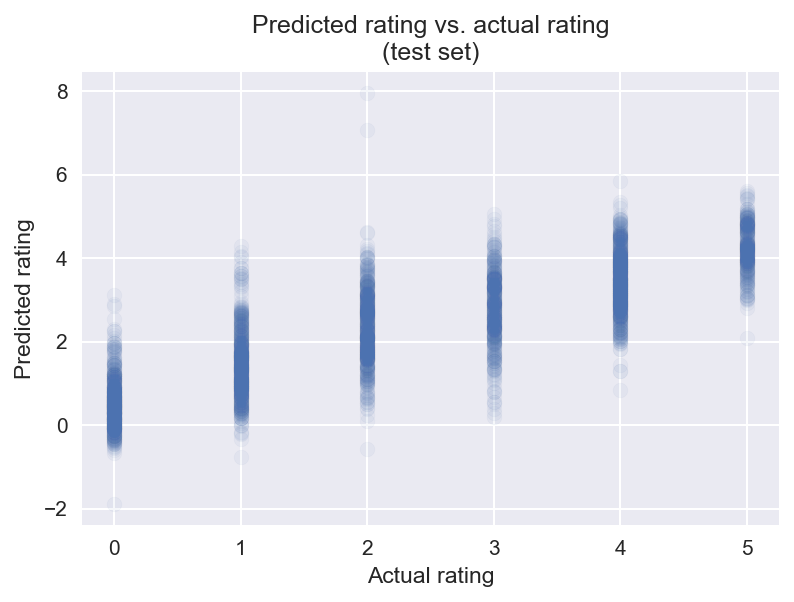

In [43]:
plt.scatter(y_test, y_test_pred, alpha=0.05)
plt.ylabel('Predicted rating')
plt.xlabel('Actual rating');
plt.title('Predicted rating vs. actual rating\n(test set)');

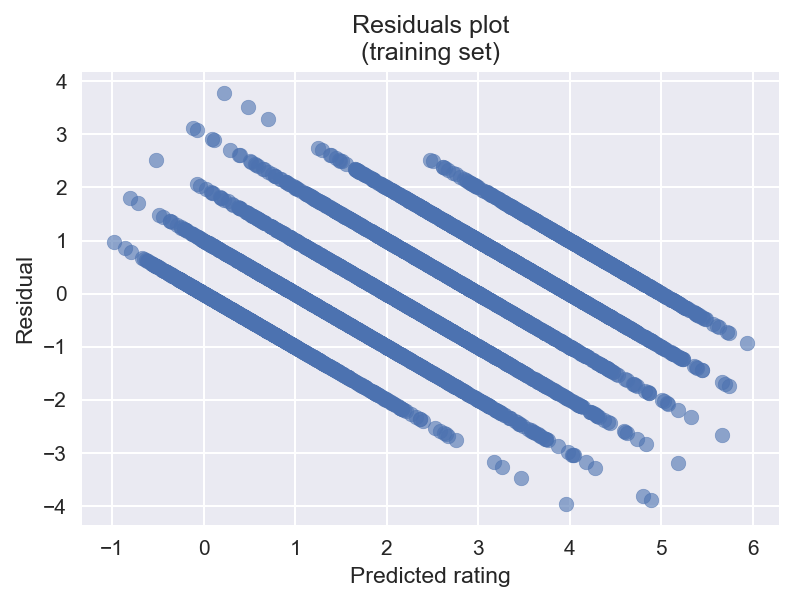

In [103]:
y_train_pred = model.predict(X_train_poly)
res = y_train - y_train_pred
plt.scatter(y_train_pred, res, alpha=0.6)
plt.xlabel('Predicted rating')
plt.ylabel('Residual')
plt.title('Residuals plot\n(training set)');

> **Note**:  The empty triangluar regions in the upper right and lower left are the result all the true ratings being in the 0 to 5 range with no exceptions. E.g., if the prediction is 0, the residuals can be in the range of 0 to 5.

## Single regressor models

Unfortunately, It didn't occur to me to run these until after I'd done my feature selection and built the more complex models. Still, they provide some interesting insights into what's happening in the more complex model, namely that that most of my predictive power is coming from word count.

In [21]:
scores = []
for feature in data.complex_features:
    X_train, X_test, y_train, y_test = data.get_X_y([feature], transformed_df)
    fold_scores = cross_val_score(LinearRegression(), X_train, y_train)
    scores.append(np.mean(fold_scores))

scores_df = pd.DataFrame(scores, index=data.complex_features, columns=['R^2'])
scores_df.sort_values(inplace=True, by='R^2', ascending=False)
scores_df

,R^2
Words (log),0.542076
External links (log),0.316510
Total edits (log),0.299527
References,0.297694
File links (log),0.263080
Unique references,0.241305
Editors (log),0.184210
Pageviews (60 days) (log),0.166979
Links to this page (log),0.163899
Sections,0.145399


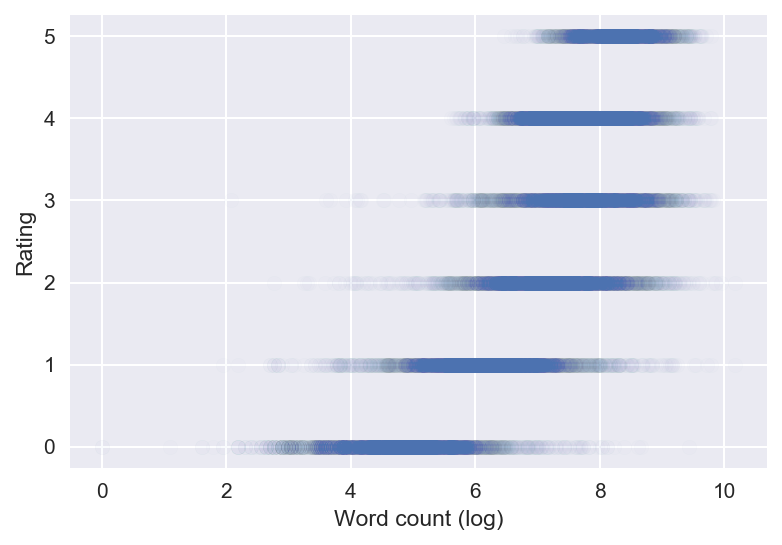

In [106]:
plt.scatter(transformed_df['Words (log)'], transformed_df['Rating'], alpha=0.01)
plt.ylabel('Rating')
plt.xlabel('Word count (log)');

## Other linear models
I tried a cubic model, but that overfit badly. I also evaluated adding lasso regularization, using grid search to tune the parameter, but that too made the model worse.

## Neural network model

For fun, I tried running the data through a vanilla neural network (one hidden layer, relu activation, dropout for regularization). It did a bit better than the quadratic model on the same features, at a cost of interpretability and way more complexity (roughly 1000 times the number of parameters).

In [145]:
K.clear_session()
inputs = Input(shape=(X_train.shape[1],))
dense = Dense(128, activation='relu')(inputs)
dropout = Dropout(0.5)(dense)
dense = Dense(128, activation='relu')(dropout)
dropout = Dropout(0.5)(dense)
output = Dense(1, activation='relu')(dropout)

model = Model(inputs, output)

model.compile(loss='mse',
              optimizer='rmsprop',
              metrics=[utils.r2])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 18,689
Trainable params: 18,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
weights_path = 'wikigrader/data/nn_weights.hdf5'
model_path = 'wikigrader/data/nn_model.hdf5'

checkpointer = ModelCheckpoint(filepath=weights_path, save_best_only=True)
model.fit(X_train.as_matrix(), y_train.as_matrix(), batch_size=128, 
          epochs=1000, validation_split=0.2, callbacks=[checkpointer])

In [151]:
model.load_weights(weights_path)
model.save('wikigrader/data/nn_model.hdf5')

In [16]:
model = load_model('wikigrader/data/nn_model.hdf5', custom_objects={'r2': utils.r2})

In [156]:
y_train_pred = model.predict(X_train.as_matrix())
utils.metrics(y_train, y_train_pred)

,Score
R^2,0.766819
RMSE,0.797531
MAE,0.588366


In [157]:
y_test_pred = model.predict(X_test.as_matrix())
utils.metrics(y_test, y_test_pred)

,Score
R^2,0.725147
RMSE,0.864729
MAE,0.645892


## Testing the tool

In [22]:
# Predict the rating of known stub article.
predict.predict_score('Stuart_Bithell')

0.0

In [23]:
# Predict the rating of a known B class article.
predict.predict_score('Wikipedia')

3.4593525

In [13]:
# Check the rating of a known FA class article.
predict.predict_score('Water_fluoridation')

4.1814356

## Conclusion

None of these models is good enough to be useful, but it's a start. The obvious next step is to look at the actual words in the articles. 